# Electricity Tariff Analysis
## Setup and Imports

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Define ElectricityTariffAnalyzer Class

In [2]:
class ElectricityTariffAnalyzer:
    def __init__(self, file_path: str):
        """
        Initialize the analyzer with the dataset file path
        """
        self.file_path = file_path
        self.raw_data = None
        self.cleaned_data = None
        self.consumption_profiles = {
            'H1': 1600, 'H2': 2500, 'H3': 4500, 'H4': 4500, 
            'H5': 7500, 'H6': 25000, 'H7': 13000, 'H8': 7500,
            'C1': 8000, 'C2': 30000, 'C3': 150000, 
            'C4': 500000, 'C5': 500000, 'C6': 1500000
        }
    

    # Data Loading Method
    def load_data(self) -> None:
        """
        Load the dataset and perform initial inspection
        """
        self.raw_data = pd.read_csv(self.file_path)
        print(f"Dataset Shape: {self.raw_data.shape}")
        print("\nColumns:", self.raw_data.columns.tolist())
        print("\nMissing Values:\n", self.raw_data.isnull().sum())

    # Data Cleaning Method
    def clean_data(self) -> None:
        """
        Comprehensive data cleaning process
        """
        df = self.raw_data.copy()
    
        # Rename columns to more manageable names
        column_mapping = {
        'Canton': 'canton',
        'Consumption profiles of typical households': 'profile',
        'Period': 'valid_from',
        'Product': 'product',
        'Total excl. VAT (Rp./kWH)': 'total_price',
        'Grid usage (Rp./kWH)': 'grid_usage_price',
        'Energy supply costs (Rp./kWH)': 'energy_price',
        'Community fees (Rp./kWH)': 'taxes',
            'Feed-in remuneration at cost (KEV) (Rp./kWH)': 'renewable_surcharge'
        }
        df = df.rename(columns=column_mapping)
    
        # Convert date columns to datetime
        df['valid_from'] = pd.to_datetime(df['valid_from'])
    
        # Handle missing values
        numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
        categorical_columns = df.select_dtypes(include=['object']).columns
    
        # Fill numeric missing values with median
        for col in numeric_columns:
            df[col].fillna(df[col].median(), inplace=True)
        
        # Fill categorical missing values with mode
        for col in categorical_columns:
            df[col].fillna(df[col].mode()[0], inplace=True)
    
        # Extract profile code from the profile description
        df['profile'] = df['profile'].str.extract(r'(H\d|C\d)')
        
        # Add consumption profile categories
        df['consumption_category'] = df['profile'].map(
            lambda x: 'Household' if x.startswith('H') else 'Commercial'
        )
    
        # Add annual consumption volume
        df['annual_consumption'] = df['profile'].map(self.consumption_profiles)
    
        # Convert prices from Rp./kWH to CHF/kWH for easier interpretation
        price_columns = ['total_price', 'grid_usage_price', 'energy_price', 
                    'taxes', 'renewable_surcharge']
        for col in price_columns:
            df[col] = df[col] / 100  # Convert Rappen to CHF
    
        self.cleaned_data = df

    # Tariff Component Analysis Method
    def analyze_tariff_components(self) -> pd.DataFrame:
        """
        Analyze the breakdown of tariff components
        """
        components = ['energy_price', 'grid_usage_price', 
                 'taxes', 'renewable_surcharge']  # Fixed incomplete list
    
        analysis = self.cleaned_data.groupby('canton')[components].agg({
            'energy_price': ['mean', 'std', 'min', 'max'],
            'grid_usage_price': ['mean', 'std', 'min', 'max'],
            'taxes': ['mean', 'std', 'min', 'max'],
            'renewable_surcharge': ['mean', 'std', 'min', 'max']
        }).round(3)
    
        return analysis
    
    # Temporal Analysis Method  

    def create_temporal_analysis(self) -> Dict[str, pd.DataFrame]:
        """
        Analyze temporal trends in electricity prices
        """
        temporal_data = {}
    
        # Monthly trends
        monthly_trends = self.cleaned_data.groupby(
            [self.cleaned_data['valid_from'].dt.to_period('M'), 'canton']
        )['total_price'].mean().reset_index()
    
        # Convert Period to string for JSON serialization
        monthly_trends['valid_from'] = monthly_trends['valid_from'].astype(str)
    
        # Seasonal patterns
        self.cleaned_data['season'] = self.cleaned_data['valid_from'].dt.month.map(
            lambda x: 'Winter' if x in [12, 1, 2] else
            'Spring' if x in [3, 4, 5] else
            'Summer' if x in [6, 7, 8] else 'Fall'
        )
    
        seasonal_patterns = self.cleaned_data.groupby(
            ['season', 'canton', 'profile']
        )['total_price'].mean().reset_index()
    
        temporal_data['monthly'] = monthly_trends
        temporal_data['seasonal'] = seasonal_patterns
    
        return temporal_data

    # Consumption Profile Analysis Method

    def analyze_consumption_profiles(self) -> pd.DataFrame:
        """
        Analyze pricing patterns across different consumption profiles
        """
        profile_analysis = self.cleaned_data.groupby('profile').agg({
            'total_price': ['mean', 'std', 'min', 'max'],
            'energy_price': 'mean',
            'grid_usage_price': 'mean',
            'taxes': 'mean',
            'renewable_surcharge': 'mean'
        }).round(3)
        
        return profile_analysis


    # Visualization Method
    def generate_visualizations(self) -> None:
        """
        Create comprehensive visualizations for the analysis
        """
        # Set style
        plt.style.use('seaborn')
        
        # 1. Tariff Component Distribution
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        components = ['energy_price', 'grid_usage_price', 
                     'taxes', 'renewable_surcharge']
        
        for ax, component in zip(axes.ravel(), components):
            sns.boxplot(data=self.cleaned_data, x='canton', y=component, ax=ax)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            ax.set_title(f'Distribution of {component} by Canton')
        
        plt.tight_layout()
        plt.savefig('tariff_components_distribution.png')
        
        # 2. Interactive Canton Comparison
        fig = px.box(self.cleaned_data, x='canton', y='total_price',
                    color='profile', title='Total Price Distribution by Canton and Profile')
        fig.write_html('canton_comparison.html')
        
        # 3. Time Series Analysis
        temporal_data = self.create_temporal_analysis()
        fig = px.line(temporal_data['monthly'], 
                     x='valid_from', 
                     y='total_price',
                     color='canton',
                     title='Monthly Price Trends by Canton')
        fig.write_html('temporal_trends.html')

    # Data Export Method
    def export_cleaned_data(self, output_path: str) -> None:
        """
        Export the cleaned dataset
        """
        self.cleaned_data.to_csv(output_path, index=False)
        print(f"Cleaned data exported to: {output_path}")

## Usage Example

Dataset Shape: (8605, 9)

Columns: ['Canton', 'Consumption profiles of typical households', 'Period', 'Product', 'Total excl. VAT (Rp./kWH)', 'Grid usage (Rp./kWH)', 'Energy supply costs (Rp./kWH)', 'Community fees (Rp./kWH)', 'Feed-in remuneration at cost (KEV) (Rp./kWH)']

Missing Values:
 Canton                                          0
Consumption profiles of typical households      0
Period                                          0
Product                                         0
Total excl. VAT (Rp./kWH)                       0
Grid usage (Rp./kWH)                            0
Energy supply costs (Rp./kWH)                   0
Community fees (Rp./kWH)                        0
Feed-in remuneration at cost (KEV) (Rp./kWH)    0
dtype: int64
Cleaned data exported to: cleaned_electricity_tariffs.csv

Tariff Component Analysis:
                       energy_price                   grid_usage_price        \
                               mean   std   min   max             mean   std  

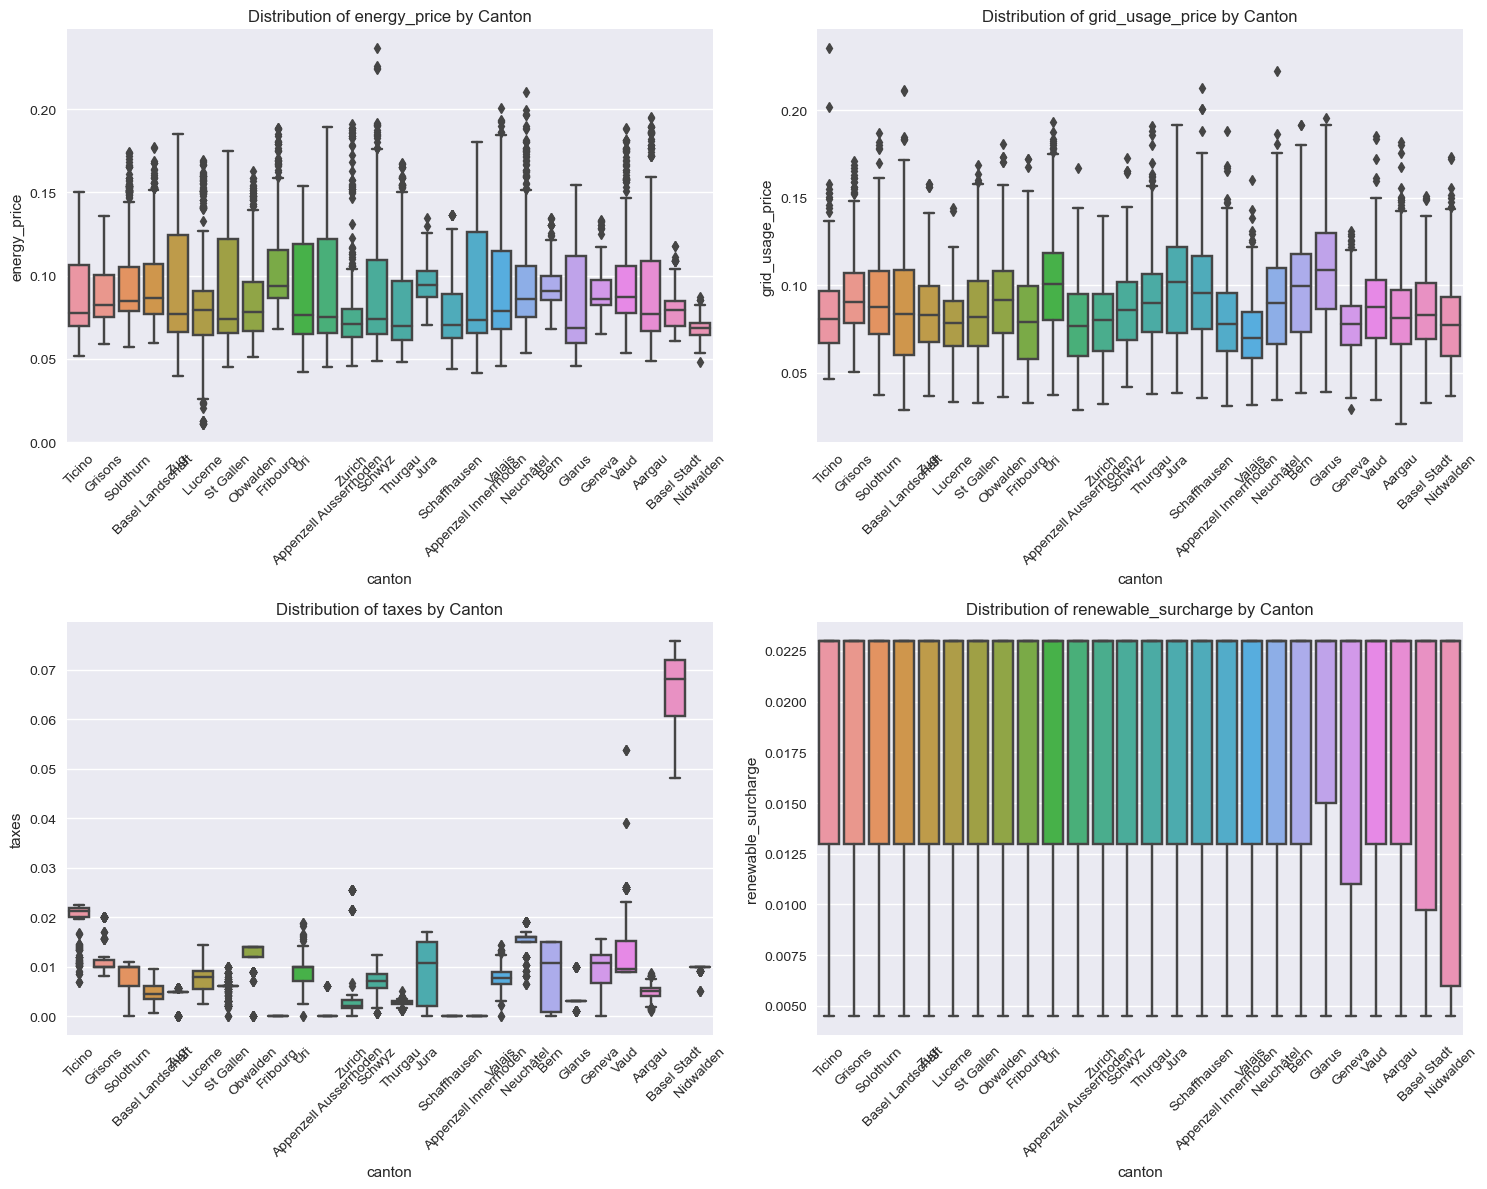

In [3]:
# Initialize analyzer with your data
analyzer = ElectricityTariffAnalyzer('median_electricity_tariff.csv')

# Load and clean data
analyzer.load_data()
analyzer.clean_data()

# Generate analyses
tariff_analysis = analyzer.analyze_tariff_components()  # Assign the result to variable
temporal_analysis = analyzer.create_temporal_analysis()
profile_analysis = analyzer.analyze_consumption_profiles()

# Create visualizations
analyzer.generate_visualizations()

# Export cleaned data
analyzer.export_cleaned_data('cleaned_electricity_tariffs.csv')

# Print summary statistics
print("\nTariff Component Analysis:")
print(tariff_analysis)
print("\nConsumption Profile Analysis:")
print(profile_analysis)